In [1]:
#Since I can't figure out how to import network_utilities, I'll just dump Elden's code here.

#===============================================================================================================================#
# This .py contains some of the standard utility functions that would be frustrating to intersperse in the Jupyter notebooks.   #
# Rather, they are included here, and should be imported in with "import network_utilities as nu"                               #
#===============================================================================================================================#

import networkx as nx

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# let's define a little function to trim the leading "4932." off protein names
# This _should_ work with any hierarchy of strings in lists.
def trim(protein_name):
    if (type(protein_name) is str):   
        # returns everything _after_ the first period.
        return '.'.join(protein_name.split(".")[1:])
    elif (type(protein_name) is list):
        trimmed_list = []
        for name in protein_name:
            trimmed_list.append(trim(name))
        return trimmed_list

# A simple QoL function to cut down a network to a given nodelist (as opposed to the converse, which nx supplies)
def cutdown_network(graph, nodelist):
    graph_copy = graph.copy(); # just to allow modification
    nodes_to_remove = set(graph.nodes) - set(nodelist);
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy
    
# My custom drawing function, with all my prefered defaults set. 
def my_draw(graph, # The networkx network to be plotted
            kkl=False, # whether to use Kamada Kawai algorithm for layout. Looks nice, but is (much) slower
            color_by_weight=True, # Edge colors by confidence weight. 
                                  # ...Most of the nice things here assume this is True. Turn off at your peril... plus it looks pretty :P
            node_color="Blue", # Either a single string "Blue", "b", "r", or a list of the colors of individual node colors in order
            node_size=10, # Similar to above
            alpha=0.8, # The _node_ opacity. Similar to above (single value or list). Note that this will be modulated
            key_text=None, # Text at the bottom of the figure
            title_text=None, # Text above figure
            
            with_labels=False, # whether to include node labels. Can get very messy.
            labels=None, # if with_labels is true, and this an array, then these labels are printed instead.
            font_size=10,
            
            delay_show=False): # whether to not run plt.show() at end. Use this if you want to include more matplotlib details,
                               # or with to run nu.draw_path_from_nodes(...) - see below 
    # "make a new figure"
    network_fig = plt.figure(figsize=(12,12))
    # Pick the layout option. At the moment I just have KK or spring. KK is much more time-intensive.
    if (kkl):
        my_layout = nx.kamada_kawai_layout(graph, weight=None);
    else:
        my_layout = nx.spring_layout(graph, k=0.5);
    # We will almost always want to color by weight... if only 'cause it is prettier!
    if (color_by_weight):
        edges = graph.edges()
        weights = [graph[u][v]['weight'] for u,v in edges]
        # Pick the colormap here if you like!
        cmap=plt.cm.plasma;
        # TODO 
        these_labels = None;
        if (with_labels and labels is None):
            node_names = list(graph.nodes);
            these_labels = {l : l for l in node_names} # note that we need to pass a dict not a list
            nx.draw_networkx_labels(graph, my_layout, labels=these_labels, font_size=font_size)
        elif (with_labels and labels is not None):
            node_names = list(graph.nodes);
            dict_labels = {node_names[l] : labels[l] for l in range(len(node_names))}
            nx.draw_networkx_labels(graph, my_layout, labels=dict_labels, font_size=font_size)
            
        nx.draw_networkx_nodes(graph, pos=my_layout, node_size=node_size, alpha=alpha, node_color=node_color)
        nx.draw_networkx_edges(graph, pos=my_layout, edge_color=weights, edge_cmap=cmap, width=0.2)

        # Adding a colorbar as per https://stackoverflow.com/questions/26739248/how-to-add-a-simple-colorbar-to-a-network-graph-plot-in-python
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
        sm._A = [];
        cb = plt.colorbar(sm, aspect=50, fraction=0.05);
        cb.set_label("Confidence score", fontsize=15);
    else:
        # If not coloring by weight... (I really haven't worked to make this that nice though!)
        nx.draw(graph, pos=my_layout, node_size=node_size, alpha=alpha, node_color=node_color, font_size='10',with_labels=False)
    # Title, and text in bottom left
    if (key_text is not None):
        network_fig.text(0.15,0.15, key_text, fontsize=15, fontweight='light')
    if (title_text is not None):
        plt.title(title_text);
    # "show the figure"
    if (delay_show is False): plt.show();
    return my_layout;

#
# draws a path on an existing network plot, from a ordered node list. 
# !! If using this with nu.my_draw(...), make sure to set delay_show=True to avoid matplotlib plt.show()-ing the figure. !!
# 'pos' is a network layout (i.e. what is returned by nx.spring_layout(graph); and the like)
# 'node_list' is a list of the node names, in order of the path. 
# '**textkwargs' are keyword arguments passed with the plt.text call - e.g. font size.
#
def draw_path_from_nodes(pos, node_list, with_labels=False, color='r', **textkwargs):
    xs = [list(pos[node])[0] for node in node_list]
    ys = [list(pos[node])[1] for node in node_list]
    plt.plot(xs,ys, color=color)
    for i in range(len(xs)):
        plt.text(xs[i],ys[i], node_list[i], textkwargs)

#
# bit of an esoteric function. Takes a list of inputs, and creates a list consisting of given results, corresponding to whether each  
# value returns true the corresponding boolean lambda test. ... feel free to ignore this!
#
def value_lambda_result(values, tests, results, default=0): 
    # 'values' a list of inputs. 'tests' a boolean lambda function. 
    # The first test to be satisfied returns its 'results'
    # 'default' is returned otherwise.
    # ...'results' can also contain lambdas, in which case, the lambda is evaluated on the corresp' value
    output = [default for i in range(len(values))]
    for v in range(len(values)):
        for t in range(len(tests)):
            if (tests[t](values[v])): 
                if (callable(results[t])): output[v] = results[t](values[v])
                else: output[v] = results[t]
                break

    return output

In [2]:
#Credit to Elden Loomes for creating the code below. Now if I could just figure out how to import network_utilities...

"""Imports and arguments"""

import csv

#import networkx as nx

#import numpy as np
#import scipy as sp
#import matplotlib.pyplot as plt
#import network_utilities as nu
import random
import networkx.algorithms.community as nx_comm

# some basic settings for plotting figures
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 20}

plt.rc('font', **font)

# THE PROTEIN OF INTEREST ================================#
this_protein = 'YNL267W';                                 #
# ========================================================#

long_outputs = True;

In [3]:
"""Loading Data"""

# This is the variable that will store the protein names. 
ess_list = [];

with open("Essential Proteins.csv", newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])
    
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("yeast_protein_edgelist_trimmed.txt",comments="#",nodetype=str)

# For interest, plot the distribution of confidence scores
#if (long_outputs):
#    plt.figure(figsize=(6,6));
#    full_edges = G0.edges()
#    these_weights = [G0[u][v]['weight'] for u,v in full_edges]

#    plt.hist(these_weights, bins=40);
#    plt.title("Confidence score distribution")
#    plt.xlabel("Confidence score")
#    plt.ylabel("# Edges")
#    plt.show();
    
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700;
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);
#print(G)

In [4]:
"""Louvain communities"""

# Run the Louvain community finding algorithm on the giant subgraph
communities = nx_comm.louvain_communities(G)
print("We have found", len(communities), "communities")
for i in range(len(communities)):
    print(i,": has",len(communities[i]), "nodes");
    
# The community containing the protein of interest
protein_comm = {'',};

# Search for the community containing the protein of interest
for c in range(len(communities)):
    if (this_protein in communities[c]): 
        print(this_protein, "is in community", c)
        #print("which consists of:", communities[c])
        #print()
        protein_comm = communities[c];

We have found 15 communities
0 : has 944 nodes
1 : has 758 nodes
2 : has 157 nodes
3 : has 79 nodes
4 : has 381 nodes
5 : has 761 nodes
6 : has 1185 nodes
7 : has 274 nodes
8 : has 3 nodes
9 : has 80 nodes
10 : has 375 nodes
11 : has 223 nodes
12 : has 211 nodes
13 : has 373 nodes
14 : has 128 nodes
YNL267W is in community 6


 
Local community of YNL267W . Without essential proteins: True
----------------------------------------------------------------------------------------------
The local community is a Graph with 988 nodes and 5550 edges
Protein YNL267W is at index 49
Geodesic distances from YNL267W range from  0 to 6
The highest 5 subgraph central nodes are ['YPL195W', 'YPR091C', 'YPL002C', 'YPL145C', 'YPL154C']
The highest 5 degree nodes are ['YPL195W', 'YPR091C', 'YPL002C', 'YPL145C', 'YPL154C']


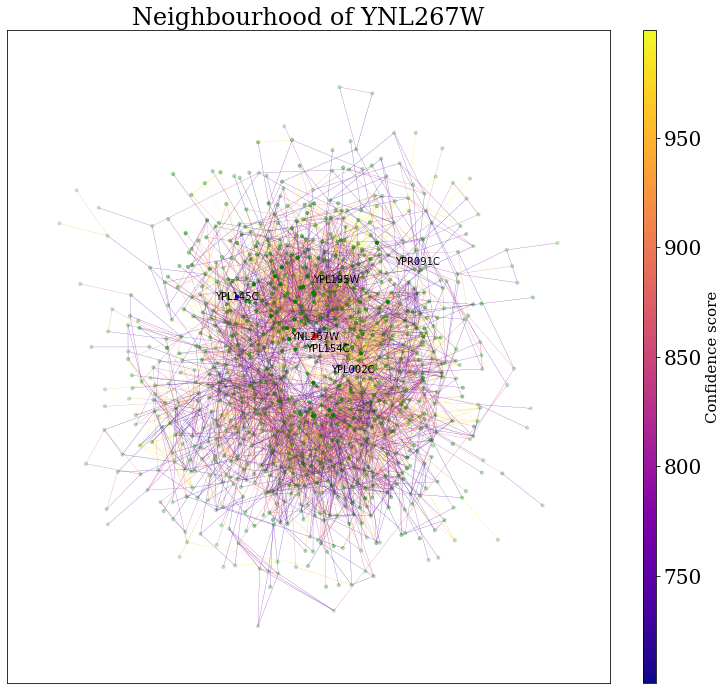

In [5]:
"""Display network with metrics"""

# Take the network of just the community of the protein of interest
#protein_comm_network = nu.cutdown_network(G, protein_comm)
protein_comm_network = cutdown_network(G, protein_comm)

removing_ess = True

if (removing_ess):
    # Let's try removing the essential nodes and plotting again:
    non_ess_comm_network = protein_comm_network.copy();
        
    this_node_list = list(protein_comm_network.nodes);
    
    trimmed_ess_list = [p for p in ess_list if p != this_protein]

    for ess_prot in trimmed_ess_list:
        if (ess_prot in this_node_list):
            non_ess_comm_network.remove_node(ess_prot)

    non_ess_index_of_protein = list(non_ess_comm_network.nodes).index(this_protein);

    protein_comm_network = non_ess_comm_network.copy();
    

    
# ------------------------------------------------------------------------------------------------------------ #
# METRICS                                                                                                      #
# We define a few metrics on which to base coloring/design                                                     #
# ------------------------------------------------------------------------------------------------------------ #

# Index of the protein of interest
index_of_protein = list(protein_comm_network.nodes).index(this_protein);

# Geodesic distance from the protein of interest:
path_lens = [];
this_node_list = list(protein_comm_network.nodes);
for i in range(len(protein_comm_network.nodes)):
    try: # just to handle disconnected
        path_len = nx.shortest_path_length(protein_comm_network, source=this_node_list[i], target=this_protein);
    except:
        path_len = 1.5 # "disconnected"
    path_lens.append(path_len);


# the first few subgraph-central nodes:
num_subgraph_central_nodes = 5;
subgraph_centrality_dict = nx.subgraph_centrality(protein_comm_network)
subgraph_central_nodes = sorted(subgraph_centrality_dict,key=lambda x: x[1], reverse=True)[:num_subgraph_central_nodes]

# the first few high degree nodes:
num_high_degree_nodes = 5;
degree_dict = {x[0]:x[1] for x in nx.degree(protein_comm_network)}
high_degree_nodes = sorted(degree_dict,key=lambda x: x[1], reverse=True)[:5]

# Text out:
print(" ")
print("==============================================================================================")
print("Local community of", this_protein, ". Without essential proteins:", removing_ess)
print("----------------------------------------------------------------------------------------------")
print("The local community is a", protein_comm_network)
print('Protein', this_protein, 'is at index', index_of_protein);
print("Geodesic distances from", this_protein, "range from ", min(path_lens), "to", max(path_lens))
print("The highest", num_subgraph_central_nodes, "subgraph central nodes are", subgraph_central_nodes)
print("The highest", num_high_degree_nodes, "degree nodes are", high_degree_nodes)
print("==============================================================================================")

# ------------------------------------------------------------------------------------------------------------ #
# DESIGN CONSTRUCTORS                                                                                          #
# We use the nu.value_lambda_result(...) function do create ordered lists of the coloring/design of nodes      #
# REMEMBER that only the result of the _first_ test to pass is displayed!                                      #
# ------------------------------------------------------------------------------------------------------------ #

#my_colors = nu.value_lambda_result(
my_colors = value_lambda_result(
    list(protein_comm_network.nodes), # values
    [lambda p: p == this_protein, lambda p: p in subgraph_central_nodes, lambda p: p in ess_list], # tests
    ['red','blue','purple'], # results
    default = 'green');  

#my_sizes = nu.value_lambda_result(
my_sizes = value_lambda_result(
    list(protein_comm_network.nodes), # values
    [lambda p: p == this_protein, lambda p: p in ess_list], #
    [20,10], # results
    default = 10);  

#my_alpha = nu.value_lambda_result(
my_alpha = value_lambda_result(
    list(protein_comm_network.nodes), # values
    [lambda p: p != this_protein], # test
    [lambda p: 1/path_lens[this_node_list.index(p)]],
    #[lambda p: 1/(nx.shortest_path_length(protein_comm_network, source=p, target=this_protein))], # results
    default = 1);  
# for some reason this is dividing by zero without the +0.1... shouldn't the lambda fix that?

#my_labels = nu.value_lambda_result(
my_labels = value_lambda_result(
    list(protein_comm_network.nodes), # values
    [lambda p: p == this_protein or p in subgraph_central_nodes], # test
    [lambda p: p], # results
    default = "");


# Draw the network
#nu.my_draw(protein_comm_network, kkl=True, node_color=my_colors, node_size=my_sizes, alpha=my_alpha,
my_draw(protein_comm_network, kkl=True, node_color=my_colors, node_size=my_sizes, alpha=my_alpha,
        #key_text="Key: red = "+this_protein+", purple = 'essential' nodes, green = other. "+
        #"\nEdges weighted by confidence. Kamada-Kawai path-length cost-function \nThreshold "+str(threshold_score), 
        title_text="Neighbourhood of "+this_protein, with_labels=True, labels=my_labels);

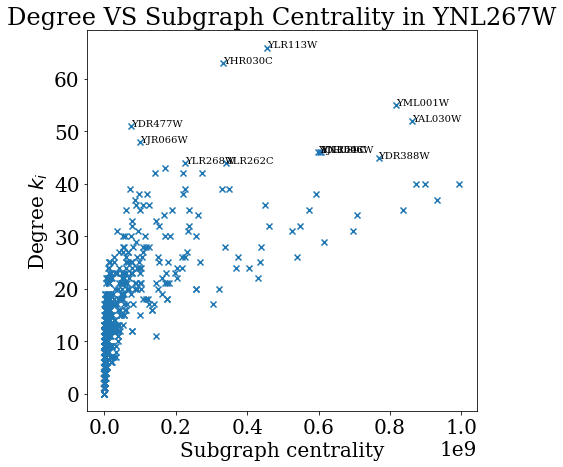

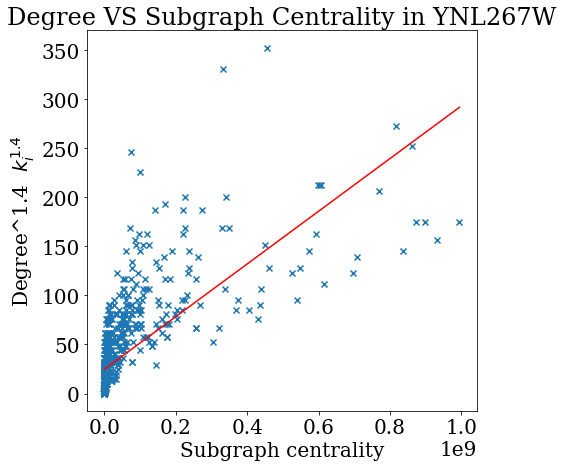

In [6]:
"""Some plots and structural analysis of this community"""

sg_central_vals = list(subgraph_centrality_dict.values())
degree_vals = list(degree_dict.values())

deg_power=1.4;
degree_vals_squ = [d**deg_power for d in degree_vals]

plt.figure(figsize=(7,7))
plt.scatter(sg_central_vals,degree_vals, marker="x")
for i in range(len(sg_central_vals)):
    if (sg_central_vals[i]>1 and degree_vals[i]>43):
        plt.text(sg_central_vals[i],degree_vals[i],this_node_list[i], fontsize=10);
        
plt.title("Degree VS Subgraph Centrality in "+this_protein)
plt.xlabel("Subgraph centrality")
plt.ylabel("Degree $k_i$")

plt.figure(figsize=(7,7))
plt.scatter(sg_central_vals,degree_vals_squ, marker="x")
plt.title("Degree VS Subgraph Centrality in "+this_protein)
plt.xlabel("Subgraph centrality")
plt.ylabel("Degree^"+str(deg_power)+"  $k_i^{"+str(deg_power)+"}$")
plt.plot(np.unique(sg_central_vals), 
         np.poly1d(np.polyfit(sg_central_vals, degree_vals_squ, 1))(np.unique(sg_central_vals)),color="r");